In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns

from random import randint
from statsmodels.stats.proportion import proportion_confint

In [14]:
def generate_data(N: int,
                  NN: int,
                  views_mean: float,
                  views_skew: float,
                  ctr_mean: float,
                  ctr_skew: float,
                  uplift: float):
    """
    Generates experimental data for N users in NN experiments
    """
    views_0 = np.exp(sps.norm(views_mean, views_skew).rvs(NN * N)).astype(np.int32).reshape(NN, N) + 1
    views_1 = np.exp(sps.norm(views_mean, views_skew).rvs(NN * N)).astype(np.int32).reshape(NN, N) + 1

    # views are always positive, abs is fixing numerical issues with high skewness
    views_0 = np.absolute(views_0)
    views_1 = np.absolute(views_1)

    alpha_0 = ctr_mean * ctr_skew / (1 - ctr_mean)
    ctrs_0 = sps.beta(alpha_0, ctr_skew).rvs(NN * N).reshape(NN, N)

    alpha_1 = ctr_mean * (1 + uplift) * ctr_skew / (1 - ctr_mean * (1 + uplift))
    ctrs_1 = sps.beta(alpha_1, ctr_skew).rvs(NN * N).reshape(NN, N)

    clicks_0 = sps.binom(n=views_0, p=ctrs_0).rvs()
    clicks_1 = sps.binom(n=views_1, p=ctrs_1).rvs()

    return (ctrs_0.astype(np.float64), clicks_0.astype(np.float64), views_0.astype(np.float64), 
            ctrs_1.astype(np.float64), clicks_1.astype(np.float64), views_1.astype(np.float64))

In [4]:
def multiple_t_test(a, b):
    """
    Calculates two-sided t-test p-values for multiple experiments
    """
    result = list(map(lambda x: sps.ttest_ind(x[0], x[1]).pvalue, zip(a, b)))
    return np.array(result)

In [5]:
def bucketization(clicks_0, views_0, clicks_1, views_1, n_buckets=200):
    """
    Does weighted bucketization and calculates p-values for all experiments using t_test
    :param ctrs_0: np.array shape (n_experiments, n_users), CTRs of every user from control group in every experiment
    :param weights_0: np.array (n_experiments, n_users), weight of every user from control group in every experiment
    :param ctrs_1: np.array (n_experiments, n_users), CTRs of every user from treatment group in every experiment
    :param weights_1: np.array (n_experiments, n_users), weight of every user from treatment group in every experiment
    :param n_buckets: int, nubmer of buckets
    :return: np.array shape (n_experiments), two-sided p-values of weighted bucketization test in all the experimetns
    """

    n_experiments, n_users = clicks_0.shape

    values_0 = np.zeros((n_experiments, n_buckets))
    values_1 = np.zeros((n_experiments, n_buckets))

    for b in np.arange(n_buckets):
        ind = np.arange(b * n_users / n_buckets, b * n_users / n_buckets + n_users / n_buckets).astype(np.int32)
        values_0[:, b] = np.sum(clicks_0[:, ind], axis=1) / np.sum(views_0[:, ind], axis=1)
        values_1[:, b] = np.sum(clicks_1[:, ind], axis=1) / np.sum(views_1[:, ind], axis=1)

    return multiple_t_test(values_0, values_1)

In [24]:
# Parameters
N = 5000
NN = 2000
views_mean = 1.0
views_skew = 1.0
ctr_mean = 0.02
ctr_skew = 250.
uplift = 0

In [25]:
ctrs_0, clicks_0, views_0, ctrs_1, clicks_1, views_1 = generate_data(N, NN, views_mean, views_skew, ctr_mean, ctr_skew, uplift)

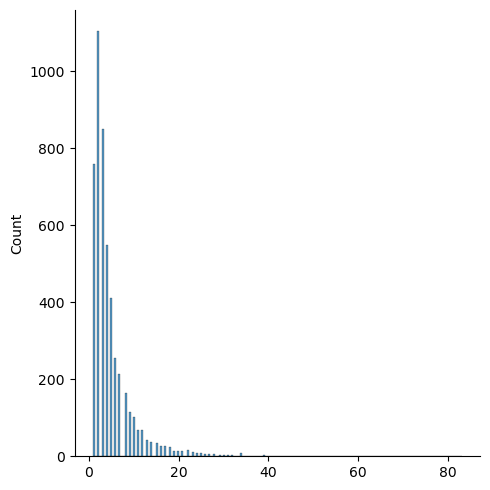

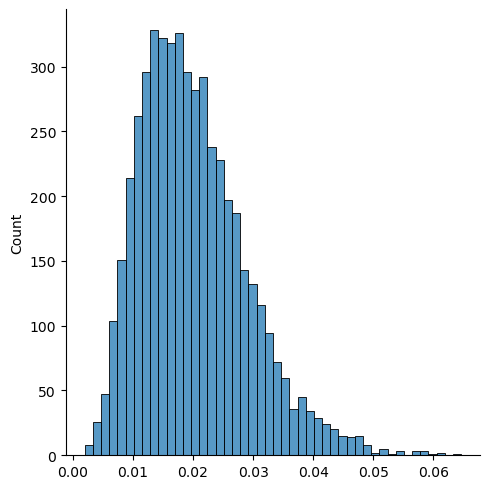

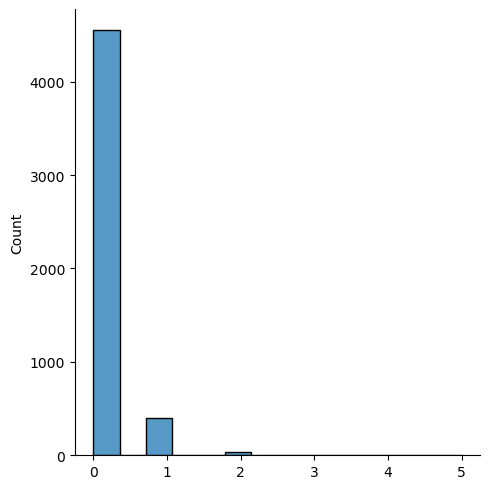

In [26]:
sns.displot(views_0[0])
sns.displot(ctrs_0[0])
sns.displot(clicks_0[0])

In [27]:
aa_results = bucketization(clicks_0, views_0, clicks_1, views_1)

In [28]:
fp = sum(1 for x in aa_results if x <= 0.05)

print(f"""
     FPR = {fp / NN} with CI {proportion_confint(count=fp, nobs=NN)}
       """)


     FPR = 0.0485 with CI (0.03908525939569529, 0.05791474060430471)
       
